In [1]:
import pandas as pd
import glob
import json
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns

In [10]:
resultdir = "/data/mtmoore/school/CSiML_AI395T/final_project/models/yolo11/iterative/validation"
resultre = re.compile(r'^.+\/(?P<modelname>[^_]+)_(?P<imgsz>[\d]+)imgsz_(?P<camera>[^_]+)_(?P<epochs>[\d]+)epochs-val$')
metricre = re.compile(r'^(?P<category>category)?_*(?P<metric>metrics/)?(?P<name>[^(]*).*?$')

model_parent = "yolo"
val_results = []

for valresult in glob.glob(f"{resultdir}/*-val"):
    
    match = resultre.match(valresult)
    if match is None:
        print(F"didn't match directory name {valresult}")
        continue
    params = match.groupdict()
    new_result = params.copy()
    new_result['modelname'] = f"{model_parent}{new_result['modelname']}"

    if not os.path.exists(f"{valresult}/metrics.json"):
        print(f"{valresult}/metrics.json doesn't exist right now, skipping")
        continue
    with open(f"{valresult}/metrics.json") as r:
        metrics = json.load(r)
        for k, v in metrics.items():
            kmatch = metricre.match(k)
            if kmatch is not None:
                md = kmatch.groupdict()
                if md['metric'] is not None:
                    k = md['name']
                    new_result[ md['name'] ] = v
                elif md['category'] is not None:
                    if len(v) == 0:
                        new_result[ f"{md['category']}_{md['name']}" ] = 0
                    else:
                        new_result[ f"{md['category']}_{md['name']}" ] = v[0]
                else:
                    new_result[ k ] = v
        val_results.append(new_result.copy())

didn't match directory name /data/mtmoore/school/CSiML_AI395T/final_project/models/yolo11/iterative/validation/11n_720imgsz_IP8M-H-SW_best-val
didn't match directory name /data/mtmoore/school/CSiML_AI395T/final_project/models/yolo11/iterative/validation/11n_2880imgsz_IP8M-H-SW_best-val
didn't match directory name /data/mtmoore/school/CSiML_AI395T/final_project/models/yolo11/iterative/validation/11s_2880imgsz_IP8M-H-SW_best-val
didn't match directory name /data/mtmoore/school/CSiML_AI395T/final_project/models/yolo11/iterative/validation/11s_720imgsz_IP8M-H-SW_best-val
didn't match directory name /data/mtmoore/school/CSiML_AI395T/final_project/models/yolo11/iterative/validation/11m_720imgsz_IP8M-H-SW_best-val
didn't match directory name /data/mtmoore/school/CSiML_AI395T/final_project/models/yolo11/iterative/validation/11m_1440imgsz_IP8M-H-SW_best-val
didn't match directory name /data/mtmoore/school/CSiML_AI395T/final_project/models/yolo11/iterative/validation/11n_1440imgsz_IP8M-H-SW_best

In [11]:
val_df = pd.DataFrame(val_results)
print(val_df.dtypes)
val_df = val_df.astype({'imgsz': 'int', 'epochs':'int',
                        'precision': 'float', 'recall': 'float', 
                        'mAP50': 'float', 'mAP50-95': 'float',
                       })
val_df.rename(columns={'imgsz': "Image Size (px)", 'epochs': 'Epochs',
                       'precision': 'Precision', 'recall': 'Recall',
                       'camera': 'Camera', 'modelname': 'Model Name',
                      }, inplace=True)
display(val_df)
val_df.dtypes

modelname             object
imgsz                 object
camera                object
epochs                object
precision            float64
recall               float64
mAP50                float64
mAP50-95             float64
fitness              float64
category_mAP50-95    float64
dtype: object


,Model Name,Image Size (px),Camera,Epochs,Precision,Recall,mAP50,mAP50-95,fitness,category_mAP50-95
0,yolo11s,2880,IP8M-H-SW,7,0.745498,0.580488,0.614247,0.283031,0.316153,0.283031
1,yolo11m,2880,IP8M-H-SW,51,0.870666,0.824390,0.882733,0.504101,0.541964,0.504101
2,yolo11n,3840,IP8M-H-SW,105,0.969188,0.946341,0.971283,0.669959,0.700091,0.669959
3,yolo11m,1440,IP8M-H-SW,105,0.849926,0.741463,0.766655,0.401539,0.438051,0.401539
4,yolo11n,3840,IP8M-H-SW,39,0.936102,0.843902,0.927118,0.556216,0.593306,0.556216
...,...,...,...,...,...,...,...,...,...,...
1754,yolo11m,1440,IP8M-H-SW,117,0.816914,0.746341,0.766580,0.426754,0.460737,0.426754
1755,yolo11m,2880,IP8M-H-SW,43,0.883361,0.738883,0.842333,0.500086,0.534311,0.500086
1756,yolo11n,3840,IP8M-H-SW,117,0.962466,0.931707,0.971178,0.688915,0.717141,0.688915
1757,yolo11m,1440,IP8M-H-SW,55,0.875056,0.682927,0.715844,0.333557,0.371786,0.333557


Model Name            object
Image Size (px)        int64
Camera                object
Epochs                 int64
Precision            float64
Recall               float64
mAP50                float64
mAP50-95             float64
fitness              float64
category_mAP50-95    float64
dtype: object

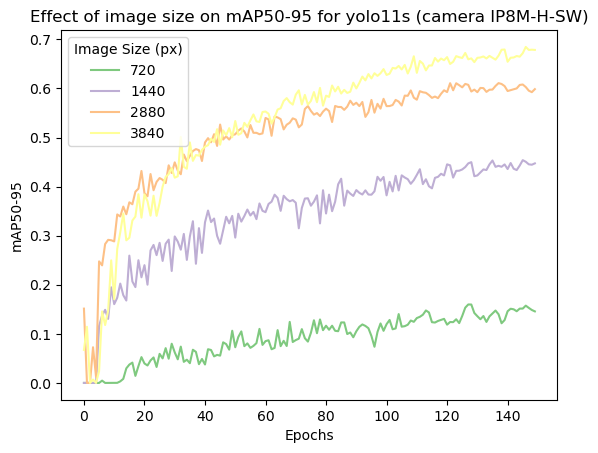

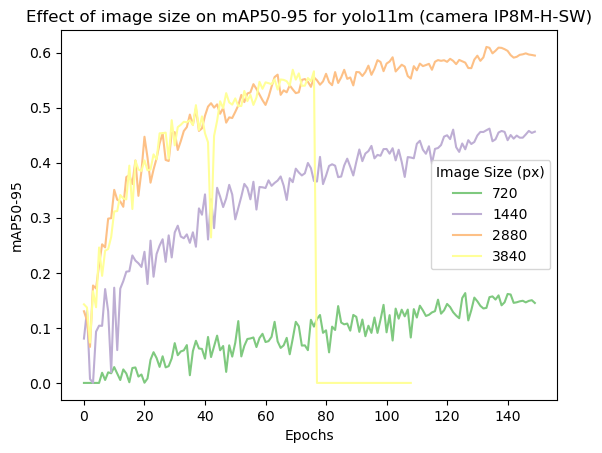

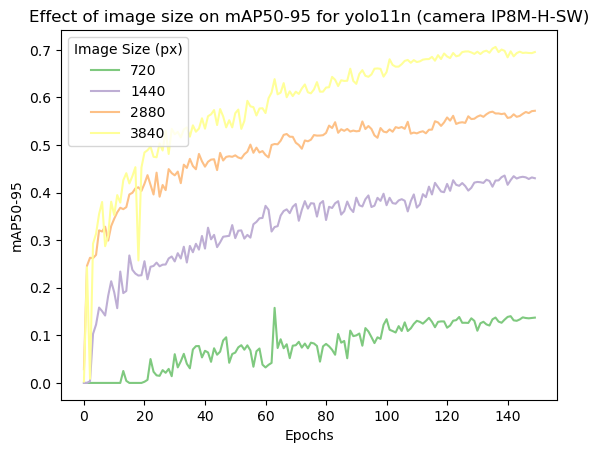

In [14]:
plot_metrics = ['Precision', 'Recall', 'mAP50', 'mAP50-95', ]

def join_mask( mask_list ):
    full_mask = None
    for m in mask_list:
        if full_mask is None:
            full_mask = m
        else:
            full_mask = full_mask & m
    return full_mask

# iterate over cameras
mask_list = []
for camera in val_df['Camera'].unique().tolist():
    mask_list.append(val_df['Camera'] == camera) 
    
    # iterate over model
    for model in val_df[join_mask( mask_list )]['Model Name'].unique().tolist(): 
        mask_list.append((val_df['Model Name'] == model))

        current_df = val_df[ join_mask( mask_list ) ]
        #display(current_df)
        for metric in ["mAP50-95"]: #plot_metrics:
            fig = plt.figure()
            axs = sns.lineplot(data=current_df, x='Epochs', y=metric, hue='Image Size (px)', palette='Accent' )
            axs.set_title(f"Effect of image size on {metric} for {model} (camera {camera})") 
        mask_list.pop()
    mask_list.pop()